In [1]:
import pandas as pd

# Read CSV with additional options
df = pd.read_csv('UpdatedDataFile.csv',
                 encoding='utf-8',           # Handle special characters
                 sep=',',                    # Specify delimiter (comma is default)
                 header=0,                   # First row as column names
                 index_col=None,             # Don't use any column as index
                 na_values=['', 'NULL'],     # Treat these as NaN
                 skiprows=0,                 # Skip rows at the beginning
                 nrows=None)                 # Read all rows (or specify number)

# Basic data exploration
print(f"DataFrame loaded with {df.shape[0]} rows and {df.shape[1]} columns")
print("\nColumn information:")
print(df.info())

DataFrame loaded with 20197 rows and 9 columns

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20197 entries, 0 to 20196
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PersonID        20197 non-null  int64  
 1   Start date      20197 non-null  object 
 2   End date        20197 non-null  object 
 3   M-Risk Factors  20197 non-null  object 
 4   Gender          20197 non-null  object 
 5   Age             20197 non-null  int64  
 6   MNA             20197 non-null  float64
 7   BMI             20197 non-null  float64
 8   Weight          20197 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 1.4+ MB
None


In [2]:
df.shape

(20197, 9)

In [3]:
# Verify before removal
print(f"Current records: {len(df):,}")
print(f"Unique persons remaining: {df['PersonID'].nunique():,}")

# Drop patient with less than 30 records (approximate 3 months)
# Count records by PersonID (assuming this is already done)
records_per_patient = df.groupby('PersonID').size().reset_index(name='Record_Count')

# Method 1: Filter patients with less than 30 records
patients_less_than_30_records = records_per_patient[records_per_patient['Record_Count'] < 30]

# Get the list of PersonIDs to remove (patients with less than 20 records)
person_ids_to_remove = patients_less_than_30_records['PersonID'].tolist()

print(f"PersonIDs to remove ({len(person_ids_to_remove)} patients):")
print(person_ids_to_remove)

df = df[~df['PersonID'].isin(person_ids_to_remove)]

# Verify removal
print(f"Remaining records: {len(df):,}")
print(f"Unique persons remaining: {df['PersonID'].nunique():,}")

Current records: 20,197
Unique persons remaining: 200
PersonIDs to remove (16 patients):
[9208, 9224, 9241, 9446, 9498, 9525, 9708, 9891, 9902, 9908, 9971, 9972, 9981, 10008, 10031, 10113]
Remaining records: 20,046
Unique persons remaining: 184


In [4]:
# Verify before removal
print(f"Current records: {len(df):,}")
print(f"Unique persons remaining: {df['PersonID'].nunique():,}")

# Drop patient with unusual and strange record
person_ids_to_remove = [8663, 8690, 8794, 9690]
df = df[~df['PersonID'].isin(person_ids_to_remove)]

# Verify removal
print(f"Remaining records: {len(df):,}")
print(f"Unique persons remaining: {df['PersonID'].nunique():,}")

Current records: 20,046
Unique persons remaining: 184
Remaining records: 19,564
Unique persons remaining: 180


In [5]:
import numpy as np

# Calculate adjusted BMI
# Check for any missing BMI or Weight values in first rows
print("\nChecking for missing values in BMI and Weight:")
print(df[['BMI', 'Weight']].isnull().sum())

# Step 1: Get the first row for each PersonID (assuming this has correct BMI)
first_rows = df.groupby('PersonID').first().reset_index()
print(f"\nNumber of unique persons: {len(first_rows)}")

# Calculate height from the first row's BMI and Weight
# BMI formula: BMI = weight(kg) / height(m)^2
# Therefore: height(m) = sqrt(weight(kg) / BMI)
first_rows['calculated_height'] = np.sqrt(first_rows['Weight'] / first_rows['BMI'])

# Check for any invalid calculations (NaN, inf, or negative values)
invalid_heights = first_rows[
    (first_rows['calculated_height'].isnull()) | 
    (first_rows['calculated_height'] <= 0) | 
    (np.isinf(first_rows['calculated_height']))
]

if len(invalid_heights) > 0:
    print(f"\nWarning: {len(invalid_heights)} persons have invalid height calculations:")
    print(invalid_heights[['PersonID', 'BMI', 'Weight', 'calculated_height']])

# Create a mapping of PersonID to height
height_mapping = first_rows[['PersonID', 'calculated_height']].set_index('PersonID')['calculated_height'].to_dict()

# Add height column to the main dataframe (rounded to 2 decimal places)
df['Height'] = df['PersonID'].map(height_mapping).round(2)

# Calculate adjusted BMI using the consistent height (rounded to 1 decimal place)
df['Adjusted_BMI'] = (df['Weight'] / (df['Height'] ** 2)).round(1)

# Display results
print("\nDataframe with new columns:")
print(df[['PersonID', 'Weight', 'BMI', 'Height', 'Adjusted_BMI']].head(10))

# Compare original vs adjusted BMI
# print("\nComparison of BMI values:")
# comparison = df[['PersonID', 'BMI', 'Adjusted_BMI']].head(10)
# comparison['BMI_Difference'] = comparison['Adjusted_BMI'] - comparison['BMI']
# print(comparison)

# Statistics on height and BMI corrections
print(f"\nHeight statistics:")
print(f"Mean height: {df['Height'].mean():.3f} m")
print(f"Height range: {df['Height'].min():.3f} - {df['Height'].max():.3f} m")

# print(f"\nBMI correction statistics:")
# bmi_diff = df['Adjusted_BMI'] - df['BMI']
# print(f"Mean BMI difference: {bmi_diff.mean():.3f}")
# print(f"BMI difference range: {bmi_diff.min():.3f} - {bmi_diff.max():.3f}")

# Save the corrected data
df.to_csv('UpdatedDataFile_adjusted_BMI.csv', index=False)
print("\nCorrected data saved as 'UpdatedDataFile_adjusted_BMI.csv'")


Checking for missing values in BMI and Weight:
BMI       0
Weight    0
dtype: int64

Number of unique persons: 180

Dataframe with new columns:
   PersonID  Weight   BMI  Height  Adjusted_BMI
0      2021   57.08  25.4     1.5          25.4
1      2021   57.08  25.4     1.5          25.4
2      2021   57.08  25.4     1.5          25.4
3      2021   57.08  25.4     1.5          25.4
4      2021   57.08  25.4     1.5          25.4
5      2021   57.08  25.4     1.5          25.4
6      2021   57.08  25.4     1.5          25.4
7      2021   57.08  25.4     1.5          25.4
8      2021   57.08  25.4     1.5          25.4
9      2021   57.08  25.4     1.5          25.4

Height statistics:
Mean height: 1.677 m
Height range: 1.260 - 2.170 m

Corrected data saved as 'UpdatedDataFile_adjusted_BMI.csv'


In [6]:
print("\nBMI Statistics (All Records):")
bmi_all_stats = df['Adjusted_BMI'].describe()
print(bmi_all_stats)


BMI Statistics (All Records):
count    19564.000000
mean        23.855423
std          5.210689
min         10.500000
25%         22.000000
50%         23.200000
75%         24.700000
max         58.500000
Name: Adjusted_BMI, dtype: float64


In [7]:
# Remove outlier
# Focus on the variables of interest
variables_of_interest = ['Adjusted_BMI']
df_subset = df[variables_of_interest + ['PersonID']].copy()

# Remove rows with missing values
df_clean = df_subset.dropna()
print(f"Original dataset: {df_subset.shape[0]} rows")
print(f"After removing missing values: {df_clean.shape[0]} rows")
print(f"Missing values removed: {df_subset.shape[0] - df_clean.shape[0]} rows")

# Basic statistics
print("\nBasic Statistics:")
print("=" * 50)
print(df_clean[variables_of_interest].describe())

Original dataset: 19564 rows
After removing missing values: 19564 rows
Missing values removed: 0 rows

Basic Statistics:
       Adjusted_BMI
count  19564.000000
mean      23.855423
std        5.210689
min       10.500000
25%       22.000000
50%       23.200000
75%       24.700000
max       58.500000



1. STATISTICAL OUTLIER DETECTION

Analyzing variable: Adjusted_BMI
------------------------------
Z-score outliers (|z| > 3): 216 points
IQR outliers: 3930 points
  Lower bound: 17.95
  Upper bound: 28.75
Modified Z-score outliers: 3106 points

2. DETAILED OUTLIER VISUALIZATION


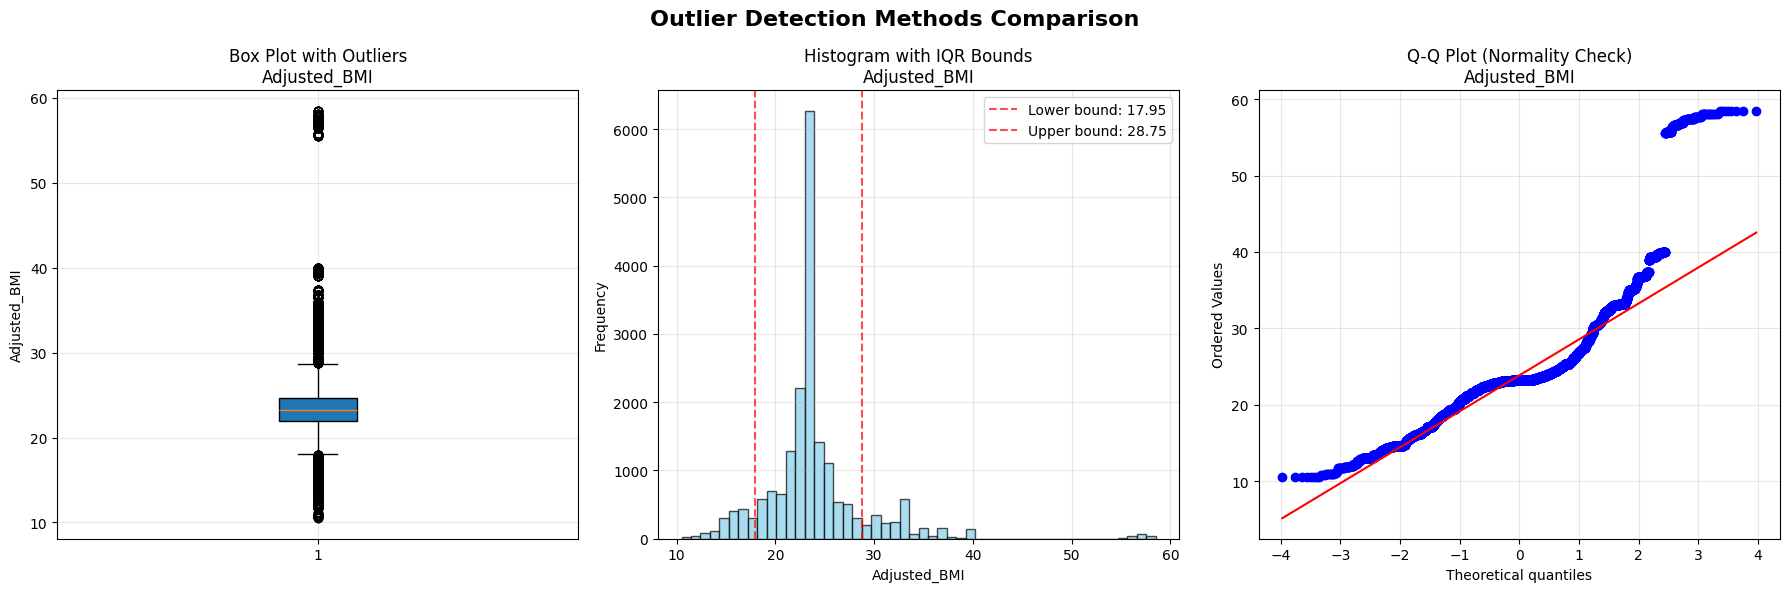

In [8]:
import matplotlib.pyplot as plt
from scipy import stats

# =====================================================
# 1. STATISTICAL OUTLIER DETECTION
# =====================================================
print("\n1. STATISTICAL OUTLIER DETECTION")
print("=" * 50)

for var in variables_of_interest:
    print(f"\nAnalyzing variable: {var}")
    print("-" * 30)
    
    data = df_clean[var]
    
    # Z-score method
    z_scores = np.abs(stats.zscore(data))
    z_outliers = data[z_scores > 3]
    print(f"Z-score outliers (|z| > 3): {len(z_outliers)} points")
    
    # IQR method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iqr_outliers = data[(data < lower_bound) | (data > upper_bound)]
    print(f"IQR outliers: {len(iqr_outliers)} points")
    print(f"  Lower bound: {lower_bound:.2f}")
    print(f"  Upper bound: {upper_bound:.2f}")
    
    # Modified Z-score method
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    modified_z_scores = 0.6745 * (data - median) / mad
    modified_z_outliers = data[np.abs(modified_z_scores) > 3.5]
    print(f"Modified Z-score outliers: {len(modified_z_outliers)} points")

# =====================================================
# 2. ADDITIONAL VISUALIZATION WITH OUTLIER BOUNDARIES
# =====================================================
print("\n2. DETAILED OUTLIER VISUALIZATION")
print("=" * 50)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Outlier Detection Methods Comparison', fontsize=16, fontweight='bold')

for i, var in enumerate(variables_of_interest):
    data = df_clean[var]
    
    # Plot 1: Box plot with outlier points highlighted
    bp = axes[0].boxplot(data, patch_artist=True)
    axes[0].set_title(f'Box Plot with Outliers\n{var}')
    axes[0].set_ylabel(var)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Histogram with outlier boundaries
    axes[1].hist(data, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
    
    # Add IQR boundaries
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    axes[1].axvline(lower_bound, color='red', linestyle='--', alpha=0.7, label=f'Lower bound: {lower_bound:.2f}')
    axes[1].axvline(upper_bound, color='red', linestyle='--', alpha=0.7, label=f'Upper bound: {upper_bound:.2f}')
    axes[1].set_title(f'Histogram with IQR Bounds\n{var}')
    axes[1].set_xlabel(var)
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Q-Q plot for normality assessment
    stats.probplot(data, dist="norm", plot=axes[2])
    axes[2].set_title(f'Q-Q Plot (Normality Check)\n{var}')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Find PersonIDs that have any records with Adjusted_BMI > 50
person_ids_with_zero_mna = df[df['Adjusted_BMI'] > 50]['PersonID'].unique()
original_records = len(df)
original_persons = df['PersonID'].nunique()

print(f"PersonIDs with Adjusted_BMI > 50: {len(person_ids_with_zero_mna)}")
print(f"Records before removal: {original_records:,}")

# Remove all records for those PersonIDs
df = df[~df['PersonID'].isin(person_ids_with_zero_mna)]

print(f"Records after removal: {len(df):,}")
print(f"Unique persons remaining: {df['PersonID'].nunique():,}")

PersonIDs with Adjusted_BMI > 50: 1
Records before removal: 19,564
Records after removal: 19,423
Unique persons remaining: 179


In [10]:
df.shape

(19423, 11)

In [11]:
# Extract all unique risk factors
all_risk_factors = []

# Iterate through each row in M-Risk Factors column
for factors in df['M-Risk Factors']:
    if pd.notna(factors) and factors != 'none':  # Skip NaN and 'none' values
        # Split by comma and strip whitespace
        factor_list = [factor.strip() for factor in str(factors).split(',')]
        all_risk_factors.extend(factor_list)

# Get unique factors and sort them
unique_risk_factors = sorted(list(set(all_risk_factors)))

# Remove any empty strings or 'none' if they exist
unique_risk_factors = [factor for factor in unique_risk_factors if factor and factor != 'none']

# print("Unique Risk Factors:")
# print("=" * 50)
# for i, factor in enumerate(unique_risk_factors, 1):
#     print(f"{i:2d}. {factor}")

print(f"\nTotal number of unique risk factors: {len(unique_risk_factors)}")


Total number of unique risk factors: 460


In [12]:
print("Analyzing M-Risk Factors column...")
print(f"Total rows: {len(df)}")

# Check for missing values in M-Risk Factors column
missing_count = df['M-Risk Factors'].isnull().sum()
print(f"Missing values in M-Risk Factors: {missing_count}")

# Remove missing values and get non-empty entries
risk_factors_series = df['M-Risk Factors'].dropna()
print(f"Non-missing entries: {len(risk_factors_series)}")

# Sample of raw data
print("\nSample of raw M-Risk Factors entries:")
print(risk_factors_series.head(10).tolist())

# Split by comma and create a list of all individual factors
all_factors = []

for entry in risk_factors_series:
    if pd.notna(entry) and str(entry).strip():  # Check if not NaN and not empty
        # Split by comma and clean each factor
        factors = [factor.strip() for factor in str(entry).split(',')]
        # Remove empty strings
        factors = [factor for factor in factors if factor]
        all_factors.extend(factors)

print(f"\nTotal individual factor entries: {len(all_factors)}")

# Get unique factors
unique_factors = list(set(all_factors))
unique_factors.sort()  # Sort alphabetically for easier reading

print(f"\nNumber of unique risk factors: {len(unique_factors)}")
# print("\nUnique Risk Factors:")
# print("=" * 50)

# for i, factor in enumerate(unique_factors, 1):
#     print(f"{i:2d}. {factor}")

# Count frequency of each factor
factor_counts = {}
for factor in all_factors:
    factor_counts[factor] = factor_counts.get(factor, 0) + 1

# Sort by frequency (most common first)
sorted_factors = sorted(factor_counts.items(), key=lambda x: x[1], reverse=True)

print(f"\nRisk Factors by Frequency:")
print("=" * 50)
print(f"{'Rank':<4} {'Factor':<30} {'Count':<8} {'Percentage':<10}")
print("-" * 54)

for i, (factor, count) in enumerate(sorted_factors[:20], 1):
    percentage = (count / len(all_factors)) * 100
    print(f"{i:<4} {factor:<30} {count:<8} {percentage:<10.1f}%")

top_20_total_count = sum(count for factor, count in sorted_factors[:20])
top_20_percentage = (top_20_total_count / len(all_factors)) * 100
print(f"Top 20 factors account for: {top_20_percentage:.1f}% of all risk factor occurrences")


Analyzing M-Risk Factors column...
Total rows: 19423
Missing values in M-Risk Factors: 0
Non-missing entries: 19423

Sample of raw M-Risk Factors entries:
['none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none']

Total individual factor entries: 182722

Number of unique risk factors: 461

Risk Factors by Frequency:
Rank Factor                         Count    Percentage
------------------------------------------------------
1    pain                           10633    5.8       %
2    dry skin                       10292    5.6       %
3    incontinence                   7529     4.1       %
4    mobility and care dependency   7347     4.0       %
5    reduced mobility               6625     3.6       %
6    wound                          5853     3.2       %
7    dementia                       5315     2.9       %
8    urinary incontinence           5232     2.9       %
9    age related decline            4493     2.5       %
10   agitation                     

In [13]:
print("Creating binary columns for risk factors...")
print(f"Original dataset shape: {df.shape}")

# First, get all unique risk factors
def get_unique_risk_factors(df):
    """Extract all unique risk factors from the dataset"""
    all_factors = []
    risk_factors_series = df['M-Risk Factors'].dropna()
    
    for entry in risk_factors_series:
        if pd.notna(entry) and str(entry).strip():
            factors = [factor.strip() for factor in str(entry).split(',')]
            # Filter out empty strings and "none" (case-insensitive)
            factors = [factor for factor in factors if factor and factor.lower() != 'none']
            all_factors.extend(factors)
    
    unique_factors = sorted(list(set(all_factors)))
    return unique_factors

# Get unique risk factors (excluding "none")
unique_factors = get_unique_risk_factors(df)
print(f"Number of unique risk factors (excluding 'none'): {len(unique_factors)}")

# Create all binary columns at once to avoid fragmentation
binary_columns = {}
for factor in unique_factors:
    # Clean column name (replace special characters that might cause issues)
    clean_factor_name = factor.replace(' ', '_').replace('-', '_').replace('/', '_').replace('(', '').replace(')', '').replace(',', '').replace('.', '')
    # Add prefix to avoid conflicts with existing columns
    column_name = f"RF_{clean_factor_name}"
    binary_columns[column_name] = 0

# Create DataFrame with all binary columns and concatenate
binary_df = pd.DataFrame([binary_columns] * len(df), index=df.index)
df = pd.concat([df, binary_df], axis=1)

print(f"Created {len(unique_factors)} binary risk factor columns")

# Function to process each row
def process_risk_factors_row(row):
    """Process M-Risk Factors for a single row and update corresponding columns"""
    m_risk_factors = row['M-Risk Factors']
    
    # If M-Risk Factors is None/NaN, all risk factor columns remain 0
    if pd.isna(m_risk_factors) or not str(m_risk_factors).strip():
        return row
    
    # Split the risk factors by comma
    factors_in_row = [factor.strip() for factor in str(m_risk_factors).split(',')]
    # Filter out empty strings and "none" (case-insensitive)
    factors_in_row = [factor for factor in factors_in_row if factor and factor.lower() != 'none']
    
    # Set corresponding columns to 1
    for factor in factors_in_row:
        clean_factor_name = factor.replace(' ', '_').replace('-', '_').replace('/', '_').replace('(', '').replace(')', '').replace(',', '').replace('.', '')
        column_name = f"RF_{clean_factor_name}"
        if column_name in row.index:
            row[column_name] = 1
    
    return row

# Apply the function to each row
print("Processing rows to set binary values...")
df = df.apply(process_risk_factors_row, axis=1)

# Get all risk factor columns for analysis
risk_factor_columns = [col for col in df.columns if col.startswith('RF_')]

print(f"\nDataset after adding risk factor columns:")
print(f"New shape: {df.shape}")
print(f"Added columns: {len(risk_factor_columns)}")

# Count rows with "none" as risk factor
none_risk_rows = df[df['M-Risk Factors'].str.strip().str.lower() == 'none'].shape[0] if 'M-Risk Factors' in df.columns else 0
no_risk_rows = df[df['M-Risk Factors'].isna()].shape[0] if 'M-Risk Factors' in df.columns else 0

print(f"\nRows with 'none' as risk factor: {none_risk_rows}")
print(f"Rows with no risk factors (M-Risk Factors is None): {no_risk_rows}")
print(f"Total rows with no actual risk factors: {none_risk_rows + no_risk_rows}")

# Verify these rows have all 0s in risk factor columns
if none_risk_rows + no_risk_rows > 0:
    no_actual_risks = df[(df['M-Risk Factors'].isna()) | (df['M-Risk Factors'].str.strip().str.lower() == 'none')]
    if len(no_actual_risks) > 0:
        sample_check = no_actual_risks[risk_factor_columns].head()
        all_zeros = (sample_check == 0).all().all()
        print(f"All risk factor columns are 0 for rows with no actual risks: {all_zeros}")

# Save the enhanced dataset
df.to_csv('UpdatedDataFile_with_binary_risk_factors.csv', index=False)
print(f"\nEnhanced dataset saved as 'UpdatedDataFile_with_binary_risk_factors.csv'")

print(f"\nSummary:")
print(f"• Original columns: {df.shape[1] - len(risk_factor_columns)}")
print(f"• Risk factor columns added: {len(risk_factor_columns)}")
print(f"• Total columns now: {df.shape[1]}")
print(f"• Rows processed: {len(df)}")

Creating binary columns for risk factors...
Original dataset shape: (19423, 11)
Number of unique risk factors (excluding 'none'): 460
Created 460 binary risk factor columns
Processing rows to set binary values...

Dataset after adding risk factor columns:
New shape: (19423, 471)
Added columns: 460

Rows with 'none' as risk factor: 3942
Rows with no risk factors (M-Risk Factors is None): 0
Total rows with no actual risk factors: 3942
All risk factor columns are 0 for rows with no actual risks: True

Enhanced dataset saved as 'UpdatedDataFile_with_binary_risk_factors.csv'

Summary:
• Original columns: 11
• Risk factor columns added: 460
• Total columns now: 471
• Rows processed: 19423


In [14]:
# Create malnutrition categories based on Adjusted_BMI
def categorize_malnutrition(bmi):
    """
    Categorize BMI into malnutrition levels based on MI-Based Criteria
    """
    if pd.isna(bmi):
        return 'Unknown'
    elif bmi < 16.0:
        return 'Severe Acute Malnutrition'
    elif bmi >= 16.0 and bmi < 17.0:
        return 'Moderate Acute Malnutrition'
    elif bmi >= 17.0 and bmi < 18.5:
        return 'Underweight'
    else:
        return 'Normal/Overweight'

def create_ordinal_malnutrition(bmi):
    """
    Create ordinal malnutrition variable with numerical codes
    0 = Severe Acute Malnutrition (most severe)
    1 = Moderate Acute Malnutrition  
    2 = Underweight
    3 = Normal/Overweight (least severe)
    -1 = Unknown/Missing
    """
    if pd.isna(bmi):
        return -1
    elif bmi < 16.0:
        return 0  # Severe Acute Malnutrition
    elif bmi >= 16.0 and bmi < 17.0:
        return 1  # Moderate Acute Malnutrition
    elif bmi >= 17.0 and bmi < 18.5:
        return 2  # Underweight
    else:
        return 3  # Normal/Overweight

# OPTION 1: Fix fragmentation by copying the DataFrame first
df = df.copy()  # This defragments the DataFrame

# Apply the categorization to create both variables
df['Malnutrition_Category'] = df['Adjusted_BMI'].apply(categorize_malnutrition)
df['Malnutrition'] = df['Adjusted_BMI'].apply(create_ordinal_malnutrition)

# OPTION 2: Alternative - Create both columns at once using pd.concat
# new_columns = pd.DataFrame({
#     'Malnutrition_Category': df['Adjusted_BMI'].apply(categorize_malnutrition),
#     'Malnutrition': df['Adjusted_BMI'].apply(create_ordinal_malnutrition)
# })
# df = pd.concat([df, new_columns], axis=1)

# Create ordered categorical version
malnutrition_order = ['Severe Acute Malnutrition', 'Moderate Acute Malnutrition', 'Underweight', 'Normal/Overweight', 'Unknown']
df['Malnutrition_Category'] = pd.Categorical(df['Malnutrition_Category'], categories=malnutrition_order, ordered=True)

# Display the distribution of malnutrition categories
print("\n" + "="*50)
print("MALNUTRITION CATEGORIZATION RESULTS")
print("="*50)

print("\nMalnutrition category distribution:")
malnutrition_counts = df['Malnutrition_Category'].value_counts(dropna=False)
malnutrition_percentages = df['Malnutrition_Category'].value_counts(normalize=True, dropna=False) * 100

for category in malnutrition_order:
    if category in malnutrition_counts.index:
        count = malnutrition_counts[category]
        percentage = malnutrition_percentages[category]
        print(f"{category}: {count:,} ({percentage:.1f}%)")

# Show ordinal variable distribution
print("\nOrdinal variable (Malnutrition) distribution:")
ordinal_mapping = {
    0: "Severe Acute Malnutrition", 
    1: "Moderate Acute Malnutrition", 
    2: "Underweight", 
    3: "Normal/Overweight",
    -1: "Unknown/Missing"
}

ordinal_counts = df['Malnutrition'].value_counts().sort_index()
for code, label in ordinal_mapping.items():
    if code in ordinal_counts.index:
        count = ordinal_counts[code]
        percentage = (count / len(df)) * 100
        print(f"Code {code} ({label}): {count:,} ({percentage:.1f}%)")

# Show BMI ranges for each category in the actual data
print("\nActual BMI ranges by malnutrition category:")
for category in malnutrition_order:
    if category in df['Malnutrition_Category'].cat.categories:
        category_data = df[df['Malnutrition_Category'] == category]['Adjusted_BMI']
        if len(category_data) > 0:
            print(f"{category}: BMI range {category_data.min():.1f} - {category_data.max():.1f} (n={len(category_data)})")



MALNUTRITION CATEGORIZATION RESULTS

Malnutrition category distribution:
Severe Acute Malnutrition: 768 (4.0%)
Moderate Acute Malnutrition: 436 (2.2%)
Underweight: 631 (3.2%)
Normal/Overweight: 17,588 (90.6%)
Unknown: 0 (0.0%)

Ordinal variable (Malnutrition) distribution:
Code 0 (Severe Acute Malnutrition): 768 (4.0%)
Code 1 (Moderate Acute Malnutrition): 436 (2.2%)
Code 2 (Underweight): 631 (3.2%)
Code 3 (Normal/Overweight): 17,588 (90.6%)

Actual BMI ranges by malnutrition category:
Severe Acute Malnutrition: BMI range 10.5 - 15.9 (n=768)
Moderate Acute Malnutrition: BMI range 16.0 - 16.9 (n=436)
Underweight: BMI range 17.1 - 18.4 (n=631)
Normal/Overweight: BMI range 18.5 - 40.0 (n=17588)


In [15]:
# Get current column order
cols = df.columns.tolist()

# Remove Malnutrition from its current position
cols.remove('Malnutrition')

# Find the index of Adjusted_BMI and insert Malnutrition after it
adjusted_bmi_index = cols.index('Adjusted_BMI')
cols.insert(adjusted_bmi_index + 1, 'Malnutrition')

# Reorder the DataFrame
df = df[cols]

In [16]:
# Count each malnutrition level
malnutrition_counts = df['Malnutrition'].value_counts().sort_index()

print("Malnutrition Level Counts:")
print("-" * 40)

malnutrition_mapping = {
    -1: 'Unknown/Missing',
    0: 'Severe Acute Malnutrition', 
    1: 'Moderate Acute Malnutrition', 
    2: 'Underweight', 
    3: 'Normal/Overweight'
}

for code, count in malnutrition_counts.items():
    label = malnutrition_mapping.get(code, f'Code {code}')
    percentage = (count / len(df)) * 100
    print(f"Level {code:2d} ({label:<25}): {count:>6,} ({percentage:>5.1f}%)")

print(f"\nTotal records: {len(df):,}")

Malnutrition Level Counts:
----------------------------------------
Level  0 (Severe Acute Malnutrition):    768 (  4.0%)
Level  1 (Moderate Acute Malnutrition):    436 (  2.2%)
Level  2 (Underweight              ):    631 (  3.2%)
Level  3 (Normal/Overweight        ): 17,588 ( 90.6%)

Total records: 19,423


In [17]:

# modify the record such that if any RF_* factor exist (mark as 1), the subsequent record for that person will set as 1

print(f"Original data shape: {df.shape}")
print(f"Number of unique persons: {df['PersonID'].nunique()}")

# Convert date columns to datetime for proper sorting
# Use dayfirst=True to handle DD/M/YYYY format like "15/9/2019"
df['Start date'] = pd.to_datetime(df['Start date'], dayfirst=True)
df['End date'] = pd.to_datetime(df['End date'], dayfirst=True)

# Sort by PersonID and Start date to ensure chronological order
df = df.sort_values(['PersonID', 'Start date']).reset_index(drop=True)

# Identify all RF_* columns
rf_columns = [col for col in df.columns if col.startswith('RF_')]
print(f"Found {len(rf_columns)} RF_* columns")

def propagate_rf_conditions(df, rf_columns):
    """
    For each person, once an RF_* condition appears (value = 1), 
    all subsequent records for that person should also have that condition marked as 1.
    """
    print("\nStarting RF condition propagation...")
    
    # Create a copy to avoid modifying original data
    df_modified = df.copy()
    
    # Group by PersonID and process each person individually
    total_persons = df_modified['PersonID'].nunique()
    processed = 0
    
    for person_id in df_modified['PersonID'].unique():
        if processed % 1000 == 0:
            print(f"Processing person {processed + 1}/{total_persons}")
        
        # Get all records for this person (already sorted by date)
        person_mask = df_modified['PersonID'] == person_id
        person_records = df_modified.loc[person_mask].copy()
        
        # For each RF column, propagate the condition forward
        for rf_col in rf_columns:
            # Find the first occurrence of this condition (value = 1)
            condition_indices = person_records[person_records[rf_col] == 1].index
            
            if len(condition_indices) > 0:
                # Get the first occurrence index
                first_occurrence_idx = condition_indices[0]
                
                # Find the position of this index in the person's records
                person_indices = person_records.index.tolist()
                first_occurrence_pos = person_indices.index(first_occurrence_idx)
                
                # Set all subsequent records for this person to have this condition
                subsequent_indices = person_indices[first_occurrence_pos:]
                df_modified.loc[subsequent_indices, rf_col] = 1
        
        processed += 1
    
    print(f"Completed processing {total_persons} persons")
    return df_modified

# Apply the propagation
df_modified = propagate_rf_conditions(df, rf_columns)

Original data shape: (19423, 473)
Number of unique persons: 179
Found 460 RF_* columns

Starting RF condition propagation...
Processing person 1/179
Completed processing 179 persons


In [18]:
from sklearn.preprocessing import LabelEncoder

# Encode gender
le = LabelEncoder()
df_modified['Gender'] = le.fit_transform(df_modified['Gender'])
print(f"  Gender encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

  Gender encoding: {'Female': np.int64(0), 'Male': np.int64(1)}


In [19]:
# drop unnecessary columns
df_modified = df_modified.drop(columns=['MNA','M-Risk Factors', 'BMI', 'Height', 'Malnutrition_Category'])

In [20]:
# Save the trimmed set of enhanced dataset
df_modified.to_csv('UpdatedDataFile_preprocessed.csv', index=False)
print(f"\nEnhanced dataset saved as 'UpdatedDataFile_preprocessed.csv'")


Enhanced dataset saved as 'UpdatedDataFile_preprocessed.csv'


In [21]:
import pandas as pd
import numpy as np
from datetime import datetime

# Read the CSV file
df = pd.read_csv('UpdatedDataFile_preprocessed.csv')

print(f"Original dataset: {len(df)} records for {df['PersonID'].nunique()} unique persons")
print(f"Date range: {df['Start date'].min()} to {df['End date'].max()}")
print(f"Columns: {len(df.columns)} total, {len([col for col in df.columns if col.startswith('RF_')])} RF columns")

# Helper functions
def format_date(date_str):
    """Convert YYYY-MM-DD to DD/M/YYYY format"""
    if pd.isna(date_str):
        return ''
    date_obj = pd.to_datetime(date_str)
    return f"{date_obj.day}/{date_obj.month}/{date_obj.year}"

def get_bmi_score(bmi):
    """Calculate BMI score for MUST assessment"""
    if pd.isna(bmi):
        return 0
    if bmi > 20:
        return 0
    elif bmi >= 18.5:
        return 1
    else:
        return 2

def get_weight_loss_score(weight_loss_percent):
    """Calculate weight loss score for MUST assessment"""
    if weight_loss_percent < 5:
        return 0
    elif weight_loss_percent <= 10:
        return 1
    else:
        return 2

def get_must_risk(must_score):
    """Convert MUST score to risk category"""
    if must_score == 0:
        return 'Low risk'
    elif must_score == 1:
        return 'Medium risk'
    else:
        return 'High risk'

# Get all RF columns
rf_columns = [col for col in df.columns if col.startswith('RF_')]
print(f"\nProcessing {len(rf_columns)} RF columns")

# Convert date columns
df['Start date'] = pd.to_datetime(df['Start date'])
df['End date'] = pd.to_datetime(df['End date'])

# Group by PersonID and aggregate
print("\nPerforming aggregation by PersonID...")

aggregated_data = []

for person_id in df['PersonID'].unique():
    person_df = df[df['PersonID'] == person_id]
    
    # 1. Duration calculation
    min_start_date = person_df['Start date'].min()
    max_end_date = person_df['End date'].max()
    duration_start_formatted = format_date(min_start_date.strftime('%Y-%m-%d'))
    duration_end_formatted = format_date(max_end_date.strftime('%Y-%m-%d'))
    duration = f"{duration_start_formatted} - {duration_end_formatted}"
    
    # 2. Gender and Age (take first non-null values)
    gender = person_df['Gender'].iloc[0]
    age = person_df['Age'].iloc[0]
    
    # 3. Average weight
    weights = person_df['Weight'].dropna()
    avg_weight = weights.mean() if len(weights) > 0 else None
    
    # 4. Max weight loss calculation
    max_weight_loss_percent = 0
    if len(weights) > 1:
        max_weight = weights.max()
        min_weight = weights.min()
        if max_weight > 0:
            max_weight_loss_percent = ((max_weight - min_weight) / max_weight) * 100
    
    # 5. Calculate MUST score
    bmis = person_df['Adjusted_BMI'].dropna()
    avg_bmi = bmis.mean() if len(bmis) > 0 else None
    
    bmi_score = get_bmi_score(avg_bmi)
    weight_loss_score = get_weight_loss_score(max_weight_loss_percent)
    must_score = bmi_score + weight_loss_score
    must_risk = get_must_risk(must_score)
    
    # Create aggregated record
    aggregated_record = {
        'PersonID': person_id,
        'Duration': duration,
        'Gender': gender,
        'Age': age,
        'AverageWeight': round(avg_weight, 2) if avg_weight is not None else None,
        'MaxWeightLossPercent': round(max_weight_loss_percent, 2),
        'AvgAdjustedBMI': round(avg_bmi, 2) if avg_bmi is not None else None,
        'BMIScore': bmi_score,
        'WeightLossScore': weight_loss_score,
        'MUSTScore': must_score,
        'MUSTRisk': must_risk
    }
    
    # 6. Process RF columns - if any record has 1, mark as 1
    for rf_col in rf_columns:
        has_rf = (person_df[rf_col] == 1).any()
        aggregated_record[rf_col] = 1 if has_rf else 0
    
    aggregated_data.append(aggregated_record)

# Create aggregated DataFrame
df_aggregated = pd.DataFrame(aggregated_data)

print(f"Aggregation complete: {len(df_aggregated)} unique persons")

# Display summary statistics
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)

print(f"\nGender Distribution:")
print(df_aggregated['Gender'].value_counts())

print(f"\nMUST Risk Distribution:")
print(df_aggregated['MUSTRisk'].value_counts())

print(f"\nAge Statistics:")
print(f"  Range: {df_aggregated['Age'].min()} - {df_aggregated['Age'].max()} years")
print(f"  Mean: {df_aggregated['Age'].mean():.1f} years")

print(f"\nWeight Loss Statistics:")
weight_losses = df_aggregated[df_aggregated['MaxWeightLossPercent'] > 0]['MaxWeightLossPercent']
print(f"  Max weight loss: {weight_losses.max():.2f}%")
print(f"  Mean weight loss: {weight_losses.mean():.2f}%")

print(f"\nBMI Statistics:")
print(f"  Range: {df_aggregated['AvgAdjustedBMI'].min():.1f} - {df_aggregated['AvgAdjustedBMI'].max():.1f}")
print(f"  Mean: {df_aggregated['AvgAdjustedBMI'].mean():.1f}")

Original dataset: 19423 records for 179 unique persons
Date range: 2019-01-01 to 2020-11-27
Columns: 468 total, 460 RF columns

Processing 460 RF columns

Performing aggregation by PersonID...
Aggregation complete: 179 unique persons

SUMMARY STATISTICS

Gender Distribution:
Gender
1    92
0    87
Name: count, dtype: int64

MUST Risk Distribution:
MUSTRisk
High risk      63
Low risk       61
Medium risk    55
Name: count, dtype: int64

Age Statistics:
  Range: 62 - 112 years
  Mean: 86.3 years

Weight Loss Statistics:
  Max weight loss: 37.48%
  Mean weight loss: 8.47%

BMI Statistics:
  Range: 12.4 - 39.6
  Mean: 23.5


In [22]:
# drop unnecessary columns
df_aggregated = df_aggregated.drop(columns=['Duration', 'AverageWeight', 'AvgAdjustedBMI', 'BMIScore', 'WeightLossScore', 'MUSTRisk'])

In [23]:
# Save to CSV
df_aggregated.to_csv('UpdatedDataFile_aggregated.csv', index=False)
print(f"\nEnhanced dataset saved as 'UpdatedDataFile_aggregated.csv'")


Enhanced dataset saved as 'UpdatedDataFile_aggregated.csv'
